This notebook comes after `src/data/2-make_dataset.py` and it is covers different sections:
- DATAFRAMES
- REMOVING OUTLIERS
- BALANCING THE DATA
- SCALING THE DATA
- FEATURE ENGINEERING

And after that comes the different models tried:
- DECISION TREE CLASSIFIER
- RANDOM FOREST CLASSIFIER
- XGBOOST
- KNN
- NAIVE BAYES
- SVM
- PCA
- LOGISTIC REGRESSION
- LDA
- NEURAL NETWORK
- VOTING CLASSIFIER
- ADA BOOST
- GRADIENT TREE BOOSTING

Finally, the export of the final dataframes and model
- EXPORTING FINAL DATA AND MODEL

In [1]:
import pyhere
import sys
sys.path.insert(0, str(pyhere.here().resolve().joinpath("src")))
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer, StandardScaler
# from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, IsolationForest
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from scipy import stats
import joblib


# DATAFRAMES

In [2]:
csv_power_plants = pd.read_csv(utils.DIR_DATA_INTERIM/"power_plants_with_generation_transformed.csv", index_col=[0])

In [3]:
# df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v2_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v5_transformed_data_combined_with_nasa.csv", index_col=['index'])

In [4]:
# csv_power_plants.loc[0:34935, ['capacity_mw', 'primary_fuel_transformed']].index.name = "index"
csv_power_plants.index.rename('index', inplace=True)

In [5]:
df_power_plants_raw = pd.read_csv(utils.DIR_DATA_RAW/"global_power_plant_database.csv", usecols=['primary_fuel', 'other_fuel1', 'other_fuel2', 'other_fuel3'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

In [6]:

index_set_to_delete = csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])].index.tolist()
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])].index.tolist())
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])].index.tolist())

csv_power_plants.drop(index_set_to_delete, inplace = True)

# csv_power_plants.filter(like='other_fuel').columns

# csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])]
# csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])]
# csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])]

In [7]:
columns_to_combine = [
                        'capacity_mw',
                        'primary_fuel_transformed',
                        # 'other_fuel1',
                        # 'other_fuel2',
                        # 'other_fuel3',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
# df_transformed_combined = df_transformed.merge(csv_power_plants.loc[0:24360, ['capacity_mw', 'primary_fuel_transformed']],left_on="index", right_on="index")
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")

primary_fuel_transformed
Other                       18859
Solar                       10664
Wind                         5340
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

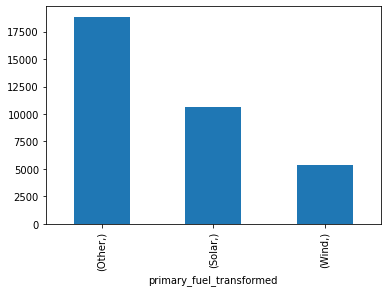

In [8]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [9]:
df_transformed_combined.describe()

,latitude,longitude,ANN_ALLSKY_SFC_LW_DWN_2013,ANN_ALLSKY_SFC_LW_DWN_2014,ANN_ALLSKY_SFC_LW_DWN_2015,ANN_ALLSKY_SFC_LW_DWN_2016,ANN_ALLSKY_SFC_LW_DWN_2017,ANN_ALLSKY_SFC_LW_DWN_2018,ANN_ALLSKY_SFC_LW_DWN_2019,ANN_ALLSKY_SFC_LW_UP_2013,...,winter_WS50M_RANGE_AVG_2018,winter_WS50M_RANGE_AVG_2019,capacity_mw,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019
count,34873.000000,34873.000000,34873.000000,34873.000000,34873.000000,34873.000000,34873.000000,34873.000000,34873.000000,34873.000000,...,34873.000000,34873.000000,34873.000000,6377.000000,7185.000000,8159.000000,9099.000000,9450.000000,9584.000000,9599.000000
mean,32.804373,-6.815115,329.230132,330.757325,332.063297,332.039128,331.408128,330.617803,329.471139,9.182810,...,4.446168,4.521671,163.369172,591.923604,656.985600,763.086646,693.874878,662.848656,517.272427,423.855623
std,22.655256,78.376089,37.046443,36.581675,37.271382,36.767882,36.535238,36.652360,37.889646,0.943828,...,1.069389,1.031110,489.754813,2172.133044,2231.008032,2533.941656,2405.992505,2371.382457,1973.958025,1697.815213
min,-77.847000,-179.977700,198.520000,198.210000,192.840000,190.880000,199.330000,198.380000,200.320000,5.590000,...,1.433333,1.473333,1.000000,-947.600000,-989.619000,-864.428000,-768.620000,-934.944000,-982.622000,-780.339000
25%,29.234700,-77.590000,306.380000,307.520000,308.460000,310.510000,309.150000,308.480000,305.770000,8.460000,...,3.680000,3.756667,4.900000,1.964000,2.261000,2.667500,2.736580,2.477500,2.244250,2.740000
50%,39.728300,-2.083300,321.090000,324.070000,322.160000,323.290000,323.240000,321.870000,319.340000,8.940000,...,4.526667,4.653333,16.700000,23.643000,23.904167,26.464000,22.638000,17.913150,12.537500,11.514000
75%,46.274400,49.870100,346.970000,347.620000,352.500000,349.880000,349.490000,350.290000,349.580000,9.800000,...,5.143333,5.210000,75.477000,200.826000,228.347819,287.114500,250.955000,216.756250,151.734325,122.870000
max,71.292000,179.388700,434.650000,432.660000,436.400000,433.900000,430.950000,429.760000,432.960000,12.250000,...,9.013333,8.670000,22500.000000,50834.000000,32320.917000,37433.607000,32377.477000,36448.643000,35136.000000,31920.368000


In [10]:
# df_transformed_combined = df_transformed_combined.loc[df_transformed_combined['generation_gwh_2013'].notna() & df_transformed_combined['generation_gwh_2014'].notna() & df_transformed_combined['generation_gwh_2015'].notna() & df_transformed_combined['generation_gwh_2016'].notna() & df_transformed_combined['generation_gwh_2017'].notna() & df_transformed_combined['generation_gwh_2018'].notna() & df_transformed_combined['generation_gwh_2019'].notna()]

primary_fuel_transformed
Other                       18859
Solar                       10664
Wind                         5340
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

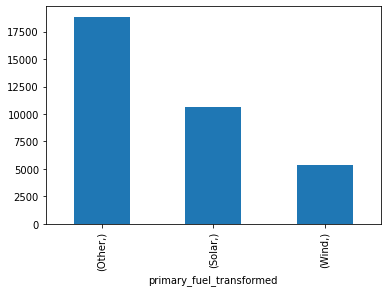

In [11]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [12]:
label_encoder = LabelEncoder()
# df_transformed_combined.isna().sum()
# df_transformed_combined[df_transformed_combined.isna().any(axis=1)]
# df_transformed_combined.dropna(inplace = True)
df_transformed_combined = df_transformed_combined[df_transformed_combined['primary_fuel_transformed'].notna()]
df_transformed_combined['code_prim_fuel_transf'] = label_encoder.fit_transform(df_transformed_combined['primary_fuel_transformed'])


In [13]:
df_target_equivalent = df_transformed_combined[['primary_fuel_transformed', 'code_prim_fuel_transf']].drop_duplicates()
df_target_equivalent = df_target_equivalent.set_index('code_prim_fuel_transf').sort_index().reset_index().drop(columns=['code_prim_fuel_transf'])
list_target_in_order = df_target_equivalent.squeeze().to_list()

# REMOVING OUTLIERS

In [14]:

columns_not_consider_outliers = [
                                    'capacity_mw',
                                    'latitude',
                                    'longitude',
                                    'primary_fuel_transformed',
                                    'code_prim_fuel_transf',
                                    'generation_gwh_2013',
                                    'generation_gwh_2014',
                                    'generation_gwh_2015',
                                    'generation_gwh_2016',
                                    'generation_gwh_2017',
                                    'generation_gwh_2018',
                                    'generation_gwh_2019'
                                ]
# X = X.loc[:,~columns_delete]                        
df_transformed_combined_remove_outliers = df_transformed_combined.drop(columns = columns_not_consider_outliers)

In [15]:
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(df_transformed_combined_remove_outliers)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [16]:
# select all rows that are outliers
mask = yhat == -1
index_outliers = df_transformed_combined[mask].index

primary_fuel_transformed
Other                       18859
Solar                       10664
Wind                         5340
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

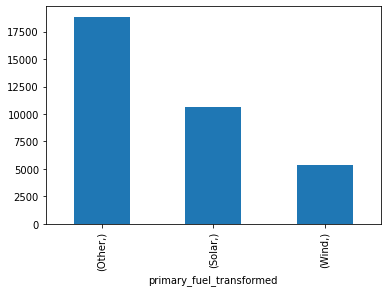

In [17]:
# WITH OUTLIERS
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

primary_fuel_transformed
Other                       16447
Solar                       10042
Wind                         4887
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

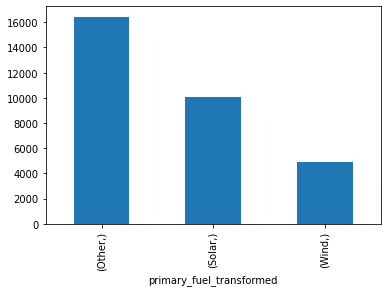

In [18]:
# WITHOUT OUTLIERS
df_transformed_combined.drop(index_outliers, axis=0, inplace =True)

print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

# BALANCING THE DATA

In [19]:
utils.balancing_data_more_than_1000(df_transformed_combined, 'primary_fuel_transformed')

<AxesSubplot:xlabel='primary_fuel_transformed'>

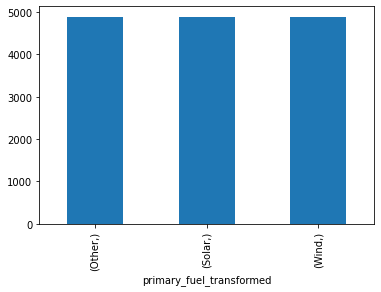

In [20]:
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [21]:
df_transformed_combined.isna().sum()

latitude                          0
longitude                         0
ANN_ALLSKY_SFC_LW_DWN_2013        0
ANN_ALLSKY_SFC_LW_DWN_2014        0
ANN_ALLSKY_SFC_LW_DWN_2015        0
                              ...  
generation_gwh_2016           10976
generation_gwh_2017           10729
generation_gwh_2018           10592
generation_gwh_2019           10422
code_prim_fuel_transf             0
Length: 642, dtype: int64

In [22]:
# index_to_drop = df_transformed_combined[df_transformed_combined['primary_fuel_transformed'] == 'Wind'].index
# df_transformed_combined.drop(index_to_drop, inplace=True)
# X = X.loc[:,~columns_delete]

In [23]:
# df_transformed_combined.isna().sum()
# df_transformed_combined[df_transformed_combined.isna().any(axis=1)]
# df_transformed_combined.dropna(inplace = True)
columns_to_drop = [
                        'capacity_mw',
                        'latitude',
                        'longitude',
                        'primary_fuel_transformed',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
pre_X = df_transformed_combined.drop(columns=columns_to_drop)
pre_X.dropna(inplace = True)
X = pre_X.drop(columns=['code_prim_fuel_transf'])
y = pre_X['code_prim_fuel_transf']

In [24]:
y.value_counts()

0    4887
1    4887
2    4887
Name: code_prim_fuel_transf, dtype: int64

# FEATURE ENGINEERING

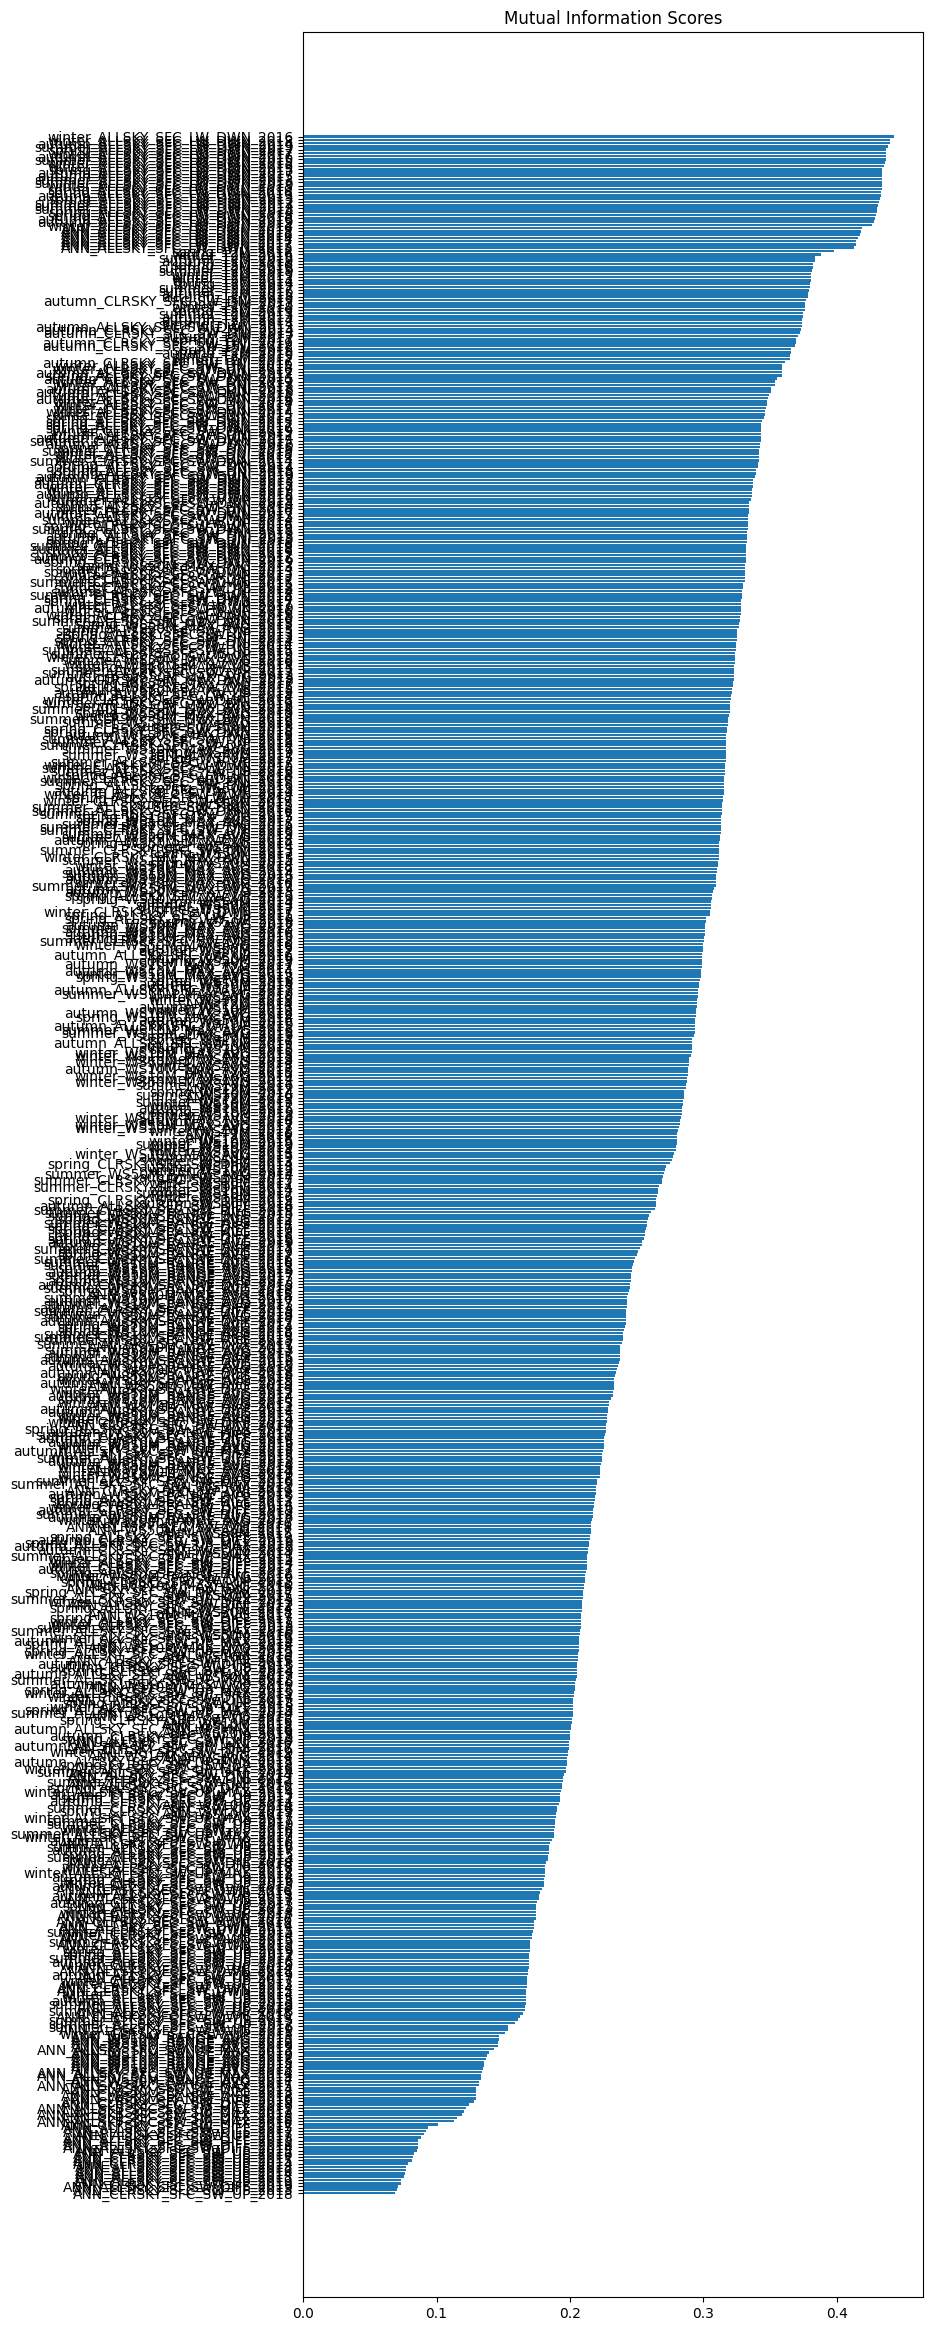

In [25]:
mi_scores = utils.make_mi_scores(X, y)
plt.figure(dpi=100, figsize=(8, 30))
utils.plot_mi_scores(mi_scores)

In [26]:
utils.calculate_feature_mean_std(X)

In [27]:
# CLIMATE_FEATURES = {'ALLSKY_SFC_SW_DWN', 
#                     'CLRSKY_SFC_SW_DWN', 
#                     'ALLSKY_KT', 
#                     'WS10M_MIN_AVG', 
#                     'WS10M_MAX_AVG', 
#                     'WS50M_MAX_AVG', 
#                     'WS50M_MIN_AVG'} 
# CLIMATE_FEATURES = {"ALLSKY_SFC_SW_DWN",
#                         "CLRSKY_SFC_SW_DWN",
#                         # "ALLSKY_SFC_SW_DIFF",
#                         # "ALLSKY_SFC_SW_UP",
#                         "ALLSKY_SFC_LW_DWN",
#                         "ALLSKY_SFC_LW_UP",
#                         "ALLSKY_SFC_SW_DNI",
#                         # "ALLSKY_SFC_SW_DNI_MAX_RD",
#                         # "ALLSKY_SFC_SW_UP_MAX",
#                         # "CLRSKY_SFC_SW_DIFF",
#                         "CLRSKY_SFC_SW_DNI",
#                         # "CLRSKY_SFC_SW_UP",
#                         #"ALLSKY_KT",
#                         "WS10M_MAX_AVG",
#                         "WS50M_MAX_AVG",
#                         "WS50M",
#                         # "WS50M_RANGE_AVG",
#                         "WS10M",
#                         "T2M",
#                         # "WS10M_RANGE_AVG"
#                     }   

# list_total = []
# for feature in CLIMATE_FEATURES:
#     feature_string = ""
    
#     for season in utils.SEASONS:
#         dict_features_to_apply_mean = {}
#         list_to_append = []
#         for year in utils.YEARS:
#             feature_string = f"{season}_{feature}_{year}"
            
#             list_to_append.append(feature_string)
#         dict_features_to_apply_mean = {f"{season}_{feature}": list_to_append}
    
#         list_total.append(dict_features_to_apply_mean)

In [28]:
# for dict_season_feature in list_total:
#     for season_feature in dict_season_feature:
#         X[f'mean_{season_feature}']= X[dict_season_feature[season_feature]].mean(axis=1)
#         X[f'std_{season_feature}']= X[dict_season_feature[season_feature]].std(axis=1)

In [29]:
#  columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('ANN') | X.columns.str.contains('autumn_CLRSKY_SFC_SW_DWN_2019')
# columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('ANN') | X.columns.str.contains('2019') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('MIN')
# columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('2019') | X.columns.str.contains('2012') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('MIN') | X.columns.str.contains('ANN')
# columns_delete = X.columns.str.contains('2019') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('ANN') #| X.columns.str.contains('WS50M_RANGE_AVG') | X.columns.str.contains('WS10M_RANGE_AVG') | X.columns.str.contains('CLRSKY_SFC_SW_UP') | X.columns.str.contains('CLRSKY_SFC_SW_DNI') | X.columns.str.contains('CLRSKY_SFC_SW_DIFF') | X.columns.str.contains('ALLSKY_SFC_SW_UP_MAX') | X.columns.str.contains('ALLSKY_SFC_SW_DNI') | X.columns.str.contains('ALLSKY_SFC_LW_UP') | X.columns.str.contains('ALLSKY_SFC_LW_DWN') | X.columns.str.contains('ALLSKY_SFC_SW_UP') | X.columns.str.contains('ALLSKY_SFC_SW_DIFF')
columns_keep = X.columns.str.contains('ANN') | X.columns.str.contains('SFC_LW_DWN') | X.columns.str.contains('2013')| X.columns.str.contains('MAX')
# columns_delete = X.columns.str.contains('WS') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('2019')
columns_delete = X.columns.str.contains('2019') | X.columns.str.contains('2012') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') |  X.columns.str.contains('ANN') |  X.columns.str.contains('LW') |  X.columns.str.contains('WS10') | X.columns.str.contains('MAX')                  
# columns_delete = X.columns.str.contains('ANN') | X.columns.str.contains('2019') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') 
# columns_delete = X.columns.str.contains('WS50M_2013') | X.columns.str.contains('WS10') | X.columns.str.contains('DNI') | X.columns.str.contains('SFC_LW_UP') | X.columns.str.contains('SFC_SW_DWN') | X.columns.str.contains('autumn') | X.columns.str.contains('winter') | X.columns.str.contains('summer') | X.columns.str.contains('spring') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('2019')
# columns_delete = X.columns.str.contains('WS50M_2013') | X.columns.str.contains('WS10') | X.columns.str.contains('autumn') | X.columns.str.contains('winter') | X.columns.str.contains('summer') | X.columns.str.contains('spring') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('2019')

# X = X.loc[:,columns_keep]
X = X.loc[:,~columns_delete]

In [30]:
X

,mean_spring_CLRSKY_SFC_SW_DWN,std_spring_CLRSKY_SFC_SW_DWN,mean_autumn_CLRSKY_SFC_SW_DWN,std_autumn_CLRSKY_SFC_SW_DWN,mean_winter_CLRSKY_SFC_SW_DWN,std_winter_CLRSKY_SFC_SW_DWN,mean_summer_CLRSKY_SFC_SW_DWN,std_summer_CLRSKY_SFC_SW_DWN,mean_spring_T2M,std_spring_T2M,...,mean_summer_ALLSKY_SFC_SW_DWN,std_summer_ALLSKY_SFC_SW_DWN,mean_spring_WS50M,std_spring_WS50M,mean_autumn_WS50M,std_autumn_WS50M,mean_winter_WS50M,std_winter_WS50M,mean_summer_WS50M,std_summer_WS50M
index,,,,,,,,,,,,,,,,,,,,,
3,8.193333,0.075425,4.328889,0.010887,5.001111,0.060431,7.648889,0.039422,15.994444,1.292150,...,7.226667,0.161314,4.570000,0.445506,3.156667,0.186238,3.332222,0.262388,5.122778,0.495820
5,8.058889,0.059951,4.202222,0.022377,4.880556,0.073618,7.352222,0.044104,22.925000,1.055411,...,6.664444,0.158810,2.794444,0.168795,2.253889,0.075819,2.324444,0.133694,2.445556,0.154340
7,8.237778,0.069815,4.232222,0.011089,4.966111,0.051701,7.690000,0.042947,22.487222,0.485732,...,7.357778,0.175546,3.379444,0.117859,2.857222,0.125174,3.244444,0.127622,3.332222,0.109720
8,8.193333,0.075425,4.328889,0.010887,5.001111,0.060431,7.648889,0.039422,18.736111,1.228964,...,7.226667,0.161314,3.891667,0.179750,2.768889,0.142184,2.790556,0.230713,3.171111,0.260825
19,7.850000,0.044920,3.973333,0.056960,4.785000,0.029496,7.180556,0.057132,17.977222,0.879253,...,6.426667,0.191195,4.983333,0.261508,5.341111,0.629203,6.496667,0.351157,4.525556,0.262718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34910,7.175556,0.122740,5.791111,0.075385,6.093889,0.109897,7.281667,0.025011,25.808889,0.928415,...,4.471667,0.293028,3.111111,0.138959,4.087778,0.228149,3.485556,0.139119,3.457778,0.402728
34921,5.951667,0.056125,7.940556,0.084811,7.746111,0.041173,6.151111,0.062704,19.660000,0.362890,...,5.898889,0.100856,6.045556,0.284798,6.339444,0.234885,4.602222,0.278541,7.283333,0.194411
34923,5.787222,0.058819,7.902222,0.084608,7.669444,0.041549,6.017778,0.056319,24.412222,0.434433,...,5.826667,0.079106,4.285556,0.193387,5.692778,0.262174,4.025000,0.275041,5.731667,0.324392


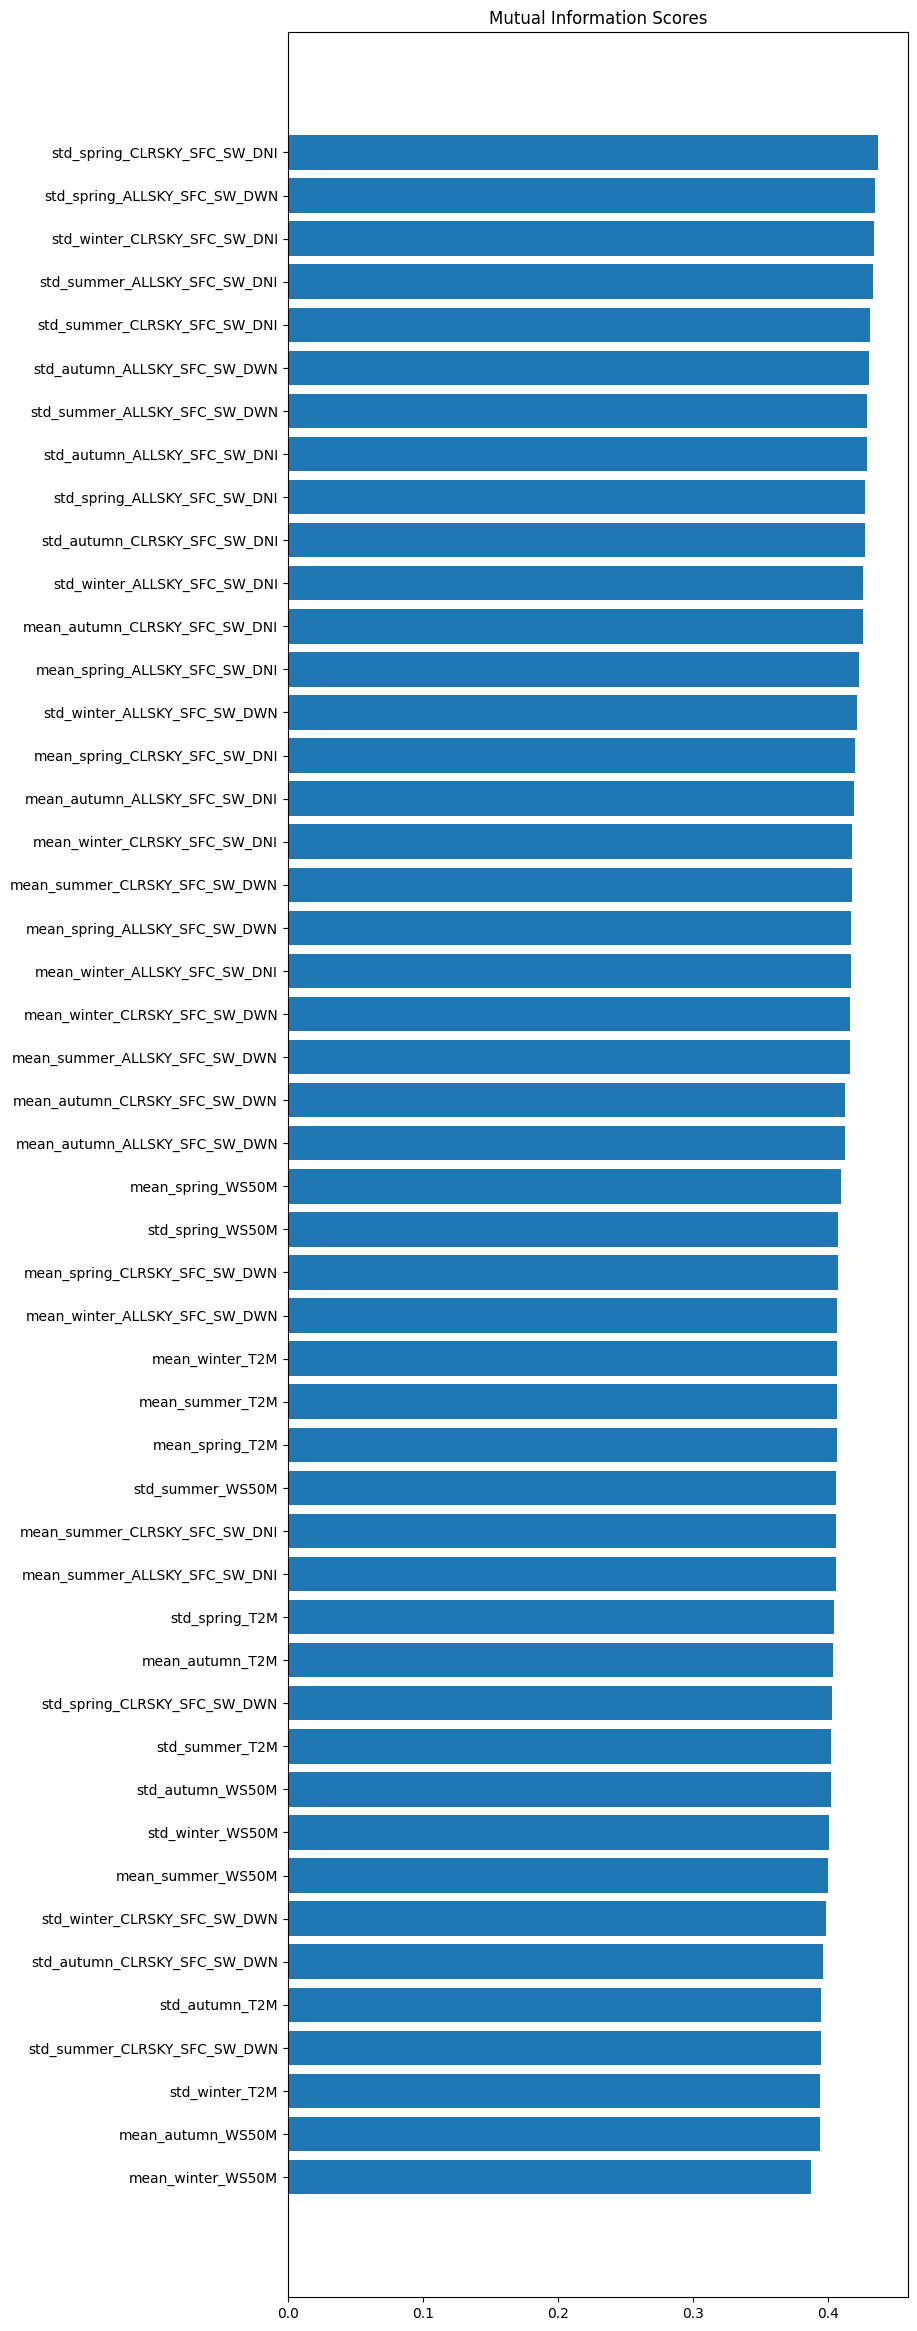

In [31]:
mi_scores = utils.make_mi_scores(X, y)
plt.figure(dpi=100, figsize=(8, 30))
utils.plot_mi_scores(mi_scores)

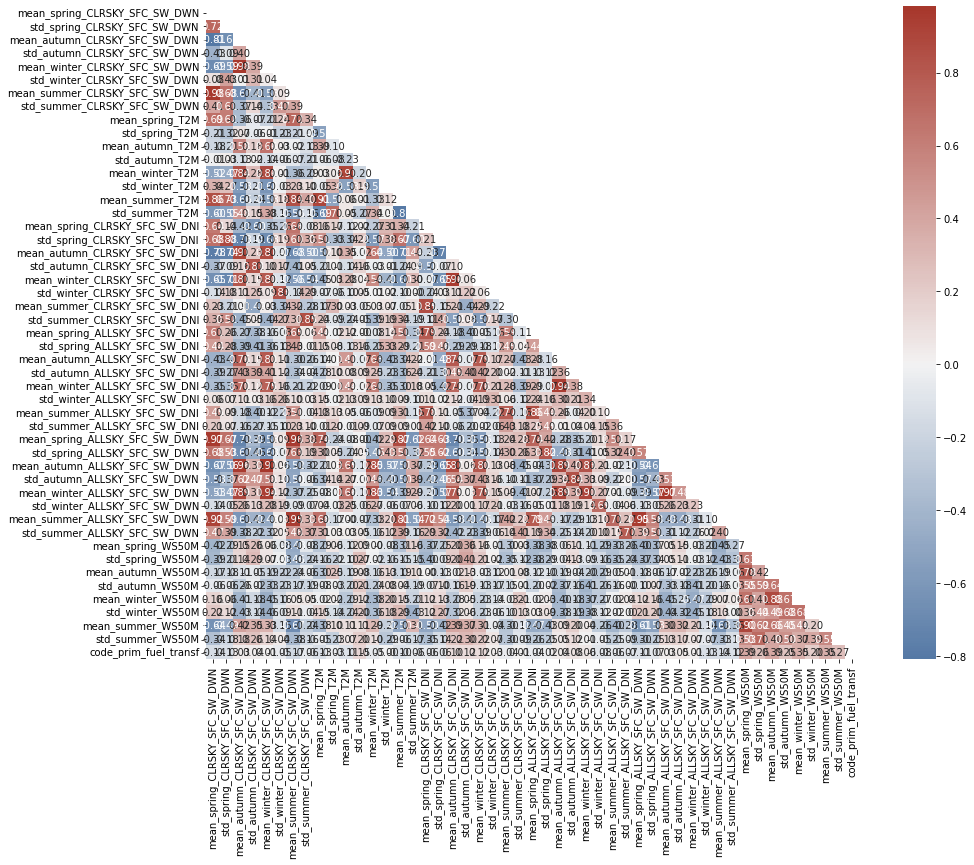

In [32]:
utils.correlation_matrix(X.join(y))

In [33]:
X = X.reindex(sorted(X.columns), axis=1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 0)

# SCALING

In [ ]:
# X_train_normalized = stats.boxcox(X_train)
x = X_train.values #returns a numpy array
min_max_scaler = MinMaxScaler()
power_transformer = PowerTransformer(method='yeo-johnson')
standard_scaler = StandardScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_train_scaled = pd.DataFrame(x_scaled, index=X_train.index, columns=X_train.columns)

x = X_test.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_test_scaled = pd.DataFrame(x_scaled, index=X_test.index, columns=X_test.columns)

x = X.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_scaled = pd.DataFrame(x_scaled, index=X.index, columns=X.columns)


# DECISION TREE CLASSIFIER

In [ ]:
candidate_max_leaf_nodes = [10, 50, 80, 100, 500, 1200, 1500]
results = {}

results = {node: utils.get_accuracy(node, X_train, X_test, y_train, y_test) for node in candidate_max_leaf_nodes}
best_tree_size = max(results, key=results.get)
print(best_tree_size)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [ ]:
tree_model = DecisionTreeClassifier(max_leaf_nodes = best_tree_size, random_state=0)
tree_model.fit(X_train, y_train)

In [ ]:
utils.custom_classification_prediction_report(tree_model, X, y, X_test, y_test, list_target_in_order)

In [ ]:
importance = tree_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: {X_train.columns[i]}, Score: {np.around(v*100,2)} %')
	# print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(30,20))
plt.bar([X_train.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

# RANDOM FOREST CLASSIFIER

In [ ]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [50, 100, 500]
# Minimum numbers of samples required to split a node
min_samples_split = [2, 10, 50 ]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [1, 10, 50, 100]
# Method of selecting samples for training each tree
bootstrap = [True, False]

max_leaf_nodes = [10, 100, 500]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes
            }



In [ ]:
rf_model = RandomForestClassifier(random_state=0)
rf_grid = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv=3, verbose = 2, n_jobs=4)
# rf_grid = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid, n_iter = 10, cv=5, verbose = 2, n_jobs=4)

In [ ]:
# rf_grid.fit(X_train_scaled_pca, y_train)
rf_grid.fit(X_train, y_train)

In [ ]:
rf_grid.best_params_

In [ ]:
rf_grid.score(X_test, y_test)
# rf_grid.score(X_test_scaled_pca, y_test)

In [ ]:
rf_model2 = RandomForestClassifier(bootstrap= False,
 max_depth= 50,
 min_samples_leaf= 1,
 min_samples_split= 10,
 n_estimators= 70,
 max_leaf_nodes= 500)
rf_model2.fit(X_train, y_train)

In [ ]:
utils.custom_classification_prediction_report(rf_model2, X, y, X_test, y_test, list_target_in_order)

In [ ]:
importance = rf_model2.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: {X_train.columns[i]}, Score: {np.around(v*100,2)} %')
	# print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(30,10))
plt.bar([X_train.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

# XGBOOST

In [35]:
xgbclass_model_1 = XGBClassifier()
xgbclass_model_1.fit(X_train, y_train)
# xgbclass_model_1.fit(X_train_scaled_pca, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [ ]:
utils.custom_classification_prediction_report(xgbclass_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:
param_grid = {
                'n_estimators': [5,10,50,100,500],
                'learning_rate': [0.001,0.01,0.05,0.1,0.2],
                'max_depth': [2,4,6],
                'gamma': [0.0,0.1,0.2]
            }

In [ ]:
# xgb_grid = GridSearchCV(estimator = XGBClassifier(), param_grid = param_grid, cv=4, verbose = 2, n_jobs=4)
xgb_grid = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = param_grid, n_iter = 20, cv=5, verbose = 1, n_jobs=4)

In [ ]:
xgb_grid.fit(X_train, y_train)

In [ ]:
xgb_grid.best_params_

In [ ]:
xgb_grid.score(X_test, y_test)

In [ ]:
# xgbclass_model_2 = XGBClassifier(n_estimators=100, learning_rate=0.2, max_depth=6, gamma=0.2, n_jobs=4)
xgbclass_model_2 = XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.2, gamma=0.1, n_jobs=4)
xgbclass_model_2.fit(X_train, y_train)

In [ ]:
utils.custom_classification_prediction_report(xgbclass_model_2, X, y, X_test, y_test, list_target_in_order)

# KNN

In [ ]:
candidate_n_neighbors = np.arange(1,31)
results = {}

# results = {n: utils.get_accuracy_knn(n, X_train_scaled_pca, X_test_scaled_pca, y_train, y_test) for n in candidate_n_neighbors}
results = {n: utils.get_accuracy_knn(n, X_train, X_test, y_train, y_test) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [ ]:
knn_model_1 = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_model_1.fit(X_train, y_train)

In [ ]:
utils.custom_classification_prediction_report(knn_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:
# def axis_calculation(total_columns_df, grid_columns):
#     rows = int(total_columns_df / grid_columns)
#     if( total_columns_df % grid_columns) > 0:
#         rows += 1

#     return (rows, grid_columns)
# print(axis_calculation(30, 4))

In [ ]:

# # plt.figure(figsize=(200,200))
# grid_columns = 5
# result_axis = axis_calculation(len(X_train_scaled.columns), grid_columns)
# fig, axs = plt.subplots(result_axis[0],result_axis[1], figsize=(30,20))
# fig.subplots_adjust(hspace=.5)

# aux_cont = 0
# aux_cont_2 = 0
# # fig.figsize=(30,30)
# for col in X_train_scaled.columns:
# # #     # print(col)
#     sns.kdeplot(data=X_train_scaled, x=col, shade=True, ax=axs[aux_cont_2, aux_cont] )
#     # axs[aux_cont_2, aux_cont].set_xlabel('Participation Rate')
#     # axs[aux_cont_2, aux_cont].set_ylabel('Frequency')
#     # axs[aux_cont_2, aux_cont].set_title("sasa")
#     axs[aux_cont_2, aux_cont].set_xticklabels([])
#     aux_cont += 1
#     if aux_cont >= grid_columns:
#         aux_cont_2 +=1
#         aux_cont = 0

In [ ]:
# X_train_scaled.hist(bins=100, xlabelsize=8, ylabelsize=10, figsize=(30,20))


In [ ]:
# WITHOUT SCALING OR NORMALIZING
# X_train.hist(bins=100, xlabelsize=8, ylabelsize=10, figsize=(30,20))

In [ ]:
candidate_n_neighbors = np.arange(1,25)
results = {}
# Write loop to find the ideal tree size from candidate_max_leaf_nodes


results = {n: utils.get_accuracy_knn(n, X_train_scaled, X_test_scaled, y_train, y_test) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [ ]:
knn_model_2 = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_model_2.fit(X_train_scaled, y_train)

In [ ]:
utils.custom_classification_prediction_report(knn_model_1, X, y, X_test, y_test, list_target_in_order)

# NAIVE BAYES

In [ ]:
nb_model_1 = GaussianNB()

#Entreno el modelo
nb_model_1.fit(X_train, y_train)

#Realizo una predicción
y_pred = nb_model_1.predict(X_test_scaled)
print(np.around(nb_model_1.score(X_test, y_test),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(nb_model_1, X, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [ ]:
nb_model_2 = GaussianNB()
nb_model_2.fit(X_train_scaled, y_train)


y_pred = nb_model_2.predict(X_test_scaled)
print(np.around(nb_model_2.score(X_test_scaled, y_test),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(nb_model_2, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# SVM

In [ ]:
svm_model_1 = SVC(decision_function_shape='ovo')
svm_model_1.fit(X_train_scaled, y_train)

In [ ]:
y_pred = svm_model_1.predict(X_test_scaled)
print(np.around(svm_model_1.score(X_test_scaled, y_test),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(svm_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [ ]:
param_grid = {
                'C': [0.5, 1, 10, 100], # NOTE: values for C must be > 0
                'gamma': ['scale', 1, .1, .01, .001, .0001],
                'kernel': ['rbf', 'linear'], # Some linear fittings last to 7/8 mins. Not recommended at all
                'decision_function_shape': ['ovo', 'ovr']
            }
# svm_grid = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
svm_grid = RandomizedSearchCV(estimator = SVC(), param_distributions = param_grid, cv=5, verbose = 2, n_jobs=4)

In [ ]:
svm_grid.fit(X_train_scaled, y_train)

In [ ]:
svm_grid.best_params_

In [ ]:
svm_grid.score(X_test_scaled, y_test)

In [ ]:
svm_model_2 = SVC(C= 0.5, gamma= 0.1, kernel='rbf', decision_function_shape= 'ovo')
svm_model_2.fit(X_train, y_train)

In [ ]:
y_pred = svm_model_2.predict(X_test_scaled)

In [ ]:
svm_model_2.score(X_test_scaled, y_test)

In [ ]:
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# PCA

In [ ]:
pca = PCA(n_components=3)
pca.fit(X_train_scaled)

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
train_pc1_coords = X_train_scaled_pca[:,0]
train_pc2_coords = X_train_scaled_pca[:,1]
train_pc3_coords = X_train_scaled_pca[:,2]

# LOGISTIC REGRESSION

In [ ]:
logistic_model_1 = LogisticRegression(multi_class= 'ovr')
logistic_model_1.fit(X_train_scaled, y_train)
y_pred = logistic_model_1.predict(X_test_scaled)
print(logistic_model_1.score(X_test_scaled, y_test))
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# LDA

In [ ]:
lda = LDA(n_components = 2)
X_train_scaled_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_scaled_lda = lda.transform(X_test_scaled)

In [ ]:
lda.fit(X_train_scaled_lda, y_train)
y_pred = lda.predict(X_test_scaled_lda)
print(lda.score(X_test_scaled_lda, y_test))
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# NEURAL NETWORK

In [ ]:
nn_model_1 = MLPClassifier(hidden_layer_sizes=(25,50,25), max_iter=200,activation = 'tanh',solver='adam',random_state=1)
nn_model_1.fit(X_train, y_train)
y_pred = nn_model_1.predict(X_test)
print(nn_model_1.score(X_test, y_test))
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# BAGGING CLASSIFIER

In [ ]:
bag_model_1 = BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=50)
bag_model_1.fit(X_train_scaled, y_train)
y_pred = bag_model_1.predict(X_test_scaled)
# print(bag_model_1.score(X_test_scaled, y_test))

# results_cvs = cross_val_score(bag_model_1, X_train_scaled, y_train, cv=5)
# print(results_cvs)
# print(f'Mean: {results_cvs.mean()}, Standard Deviation: {results_cvs.std()}')
# confusion_matrix_return = confusion_matrix(y_test, y_pred)
# sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')


print(np.around(bag_model_1.score(X_test_scaled, y_test),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(bag_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [ ]:
classifier = {
        'KNeighbors': KNeighborsClassifier(n_neighbors=9),
        'DecisionTree': DecisionTreeClassifier(max_leaf_nodes=50),
        'XGBClassifier': XGBClassifier()
    }

for name, estimator in classifier.items():
    bag_class = BaggingClassifier(base_estimator=estimator, n_estimators=5).fit(X_train_scaled, y_train)
    
    bag_pred = bag_class.predict(X_test_scaled)

    print(f'Accuracy Bagging with {name}: {accuracy_score(bag_pred, y_test)}')
    print('')
    print(f'Mean: {cross_val_score(bag_class, X, y, cv=5).mean()}, Standard Deviation: {cross_val_score(tree_model, X, y, cv=5).std()}')
    print('')

# VOTING CLASSIFIER

In [ ]:


votclass_model_1 = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier(n_neighbors=9)), ('dt', DecisionTreeClassifier(max_leaf_nodes=50)), ('xgb', XGBClassifier())], voting='hard')
votclass_model_1.fit(X_train_scaled, y_train)

y_pred = votclass_model_1.predict(X_test_scaled)

print(np.around(votclass_model_1.score(X_test_scaled, y_test),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(votclass_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# ADABOOST

In [ ]:
adaBoost_model_1 = AdaBoostClassifier(n_estimators=100)
adaBoost_model_1.fit(X_train_scaled, y_train)

y_pred = adaBoost_model_1.predict(X_test_scaled)

print(np.around(adaBoost_model_1.score(X_test_scaled, y_test),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(adaBoost_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# GRADIENT TREE BOOSTING

In [ ]:
gradboost_model_1 = GradientBoostingClassifier(n_estimators=40)
gradboost_model_1.fit(X_train, y_train)
y_pred = gradboost_model_1.predict(X_test)
print(np.around(gradboost_model_1.score(X_test, y_test),3))
# If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
results_cvs = cross_val_score(gradboost_model_1, X, y, cv=StratifiedKFold(shuffle = True))
print(np.around(results_cvs, 3))
print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# EXPORTING FINAL DATA AND MODEL

In [36]:
X.to_csv(utils.DIR_DATA_PROCESSED/"classification_X.csv")
y.to_csv(utils.DIR_DATA_PROCESSED/"classification_y.csv")
df_target_equivalent.to_csv(utils.DIR_DATA_PROCESSED/"classification_y_real_values.csv")

76.44%
[76.82 74.73 75.07 75.1  74.93](%)
Mean: 75.33%, Standard Deviation: 0.75%
              precision    recall  f1-score   support

       Other       0.74      0.68      0.71       957
       Solar       0.73      0.77      0.75       993
        Wind       0.82      0.84      0.83       983

    accuracy                           0.76      2933
   macro avg       0.76      0.76      0.76      2933
weighted avg       0.76      0.76      0.76      2933



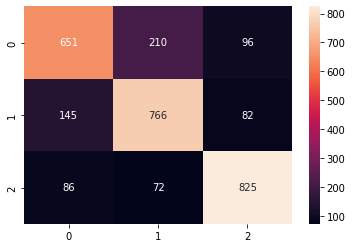

In [37]:
utils.custom_classification_prediction_report(xgbclass_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:
utils.custom_classification_prediction_report(xgbclass_model_2, X, y, X_test, y_test, list_target_in_order)

In [38]:
joblib.dump(xgbclass_model_1, utils.DIR_MODELS/"xgbclass_model_1.pkl")

['/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/models/xgbclass_model_1.pkl']